# Competition 3: Amazon Baby Reviews: screenshot

**Group Members**: Eleon Qin, Lasse Hauschel, Svenja Kratzke

## We encountered memory issues while trying to run multiple models in a single notebook, as each model requires a significant amount of memory to compute. However, we do have screenshots from when we ran the models individually using the same code and data

# 1. The project

In this competition we predict customer sentiments regarding [Baby products purchased on Amazon.com](http://jmcauley.ucsd.edu/data/amazon/), on the basis of their written reviews. 


1. Where do the data come from? (To which population will results generalize?)

The data used for this project are in english written reviews and their ratings of various baby products from Amazon.com. From looking at the reviews it can be assumed that most of the reviews come from parents or caregivers who have bought the baby products. 
Therefore, the results will most likely generalize to english speaking paretns/caregivers. 

2. What are candidate machine learning methods? (models? features?)

This competition focuses on automatic feature extraction, primarily using TF-IDF to transform text data into numerical features. Effective methods for selecting features include techniques like lasso, ridge regression, principal component regression, and partial least squares. These selected features will then be used to build the classification model.

3. What is the Bayes' error bound?

Previous research like [Gope et al. (2022)](https://doi.org/10.1080/23270012.2022.2031324) and [Norinder and Norinder (2022)](https://doi.org/10.54254/2755-2721/6/20230831) have investigated similar topics like us. They used Deep Learning models to predict the sentiment of the customers based on their product reviews and they had accuracies ranging from 95-97%.
Therefore, we think a Bayes error bound of approximately 2-5% is reasonable.

# 2. Import packages and read Data

Import R packages and locate and load the data into memory.

In [1]:
## Importing packages
library(tidyverse)
library(tidytext)
library(glmnet)

## Data attached to this notebook
list.files(path = "../input")

## Set seed for reproducibility 
set.seed(734)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8



[1] "bda-2024-sentiment-from-customer-reviews"

In [2]:
dir("../input", recursive=TRUE)

[1] "bda-2024-sentiment-from-customer-reviews/amazon_baby_testset_sample.csv"
[2] "bda-2024-sentiment-from-customer-reviews/amazon_baby.csv"

In [3]:
# Find the right file path
csv_filepath = dir("..", pattern="amazon_baby.csv", recursive=TRUE, full.names = TRUE)

# Read in the csv file
amazon = read_csv(csv_filepath) %>%
    rownames_to_column('id')

Rows: 183531 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, review
dbl (1): rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(amazon)

id,name,review,rating
<chr>,<chr>,<chr>,<dbl>
1,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",3
2,Planetwise Wipe Pouch,it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,5
3,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,NA
4,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"This is a product well worth the purchase. I have not found anything else like this, and it is a positive, ingenious approach to losing the binky. What I love most about this product is how much ownership my daughter has in getting rid of the binky. She is so proud of herself, and loves her little fairy. I love the artwork, the chart in the back, and the clever approach of this tool.",5
5,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",NA
6,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"When the Binky Fairy came to our house, we didn\'t have any special gift and book to help explain to her about how important it is to stop using a pacifier. This book does a great job to help prepare your child for the loss of their favorite item. The doll is adorable and we made lots of cute movies with the Binky Fairy telling our daughter about what happens when the Binky Fairy comes. I would highly recommend this product for any parent trying to break the pacifier or thumb sucking habit.",5


The data frame contains both the train and test data. The test data are the reviews for which the rating is missing and you need to provide a prediction. 

The following logical index variable will be of help selecting the desired rows without the need to split the data frame into seperate sets. This makes it easier to extract features.

In [5]:
trainidx = !is.na(amazon$rating)
table(trainidx)

trainidx
 FALSE   TRUE 
 30000 153531 

From the above, there are 153,531 training samples and 30,000 test samples.

# 3. Preprocessing
First, we will paste the `name` string and `review` string into a single string. In that way, we incorporate both product names and review text without the need to handle product names separately. 

Doing so will also handle another problem: Some of the reviews that are empty strings, and we wont be able to make a prediction for them. By pasting `name` and `review` we'll at least have the name to predict their rating. 

In [6]:
# Paste name and review into a single string separated by a "–".
# The new string replaces the original review.
amazon = amazon %>% 
    unite(review, name, review, sep = " — ", remove = FALSE)

print(amazon)

# A tibble: 183,531 × 4
   id    review                                                     name  rating
   <chr> <chr>                                                      <chr>  <dbl>
 1 1     "Planetwise Flannel Wipes — These flannel wipes are OK, b… "Pla…      3
 2 2     "Planetwise Wipe Pouch — it came early and was not disapp… "Pla…      5
 3 3     "Annas Dream Full Quilt with 2 Shams — Very soft and comf… "Ann…     NA
 4 4     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto…      5
 5 5     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto…     NA
 6 6     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto…      5
 7 7     "A Tale of Baby\\'s Days with Peter Rabbit — Lovely book,… "A T…      4
 8 8     "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab…     NA
 9 9     "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab…      5
10 10    "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab…      4
# ℹ 

# 3.1 Tokenization

We're going to use tidytext to break up the text into separate tokens and count the number of occurences per review. To keep track of the review to which the review belongs, we have added the rownames as `id` above, which is simply the row number. As tokens you can consider single words, pairs of words called bi-grams, or n-grams.

In [7]:
# Tokenization for reviews at unigram level
reviews_unigram <-
  amazon %>%
  unnest_tokens(unigram, review, token = "ngrams", n = 1) %>%
  # count tokens within reviews as 'n'
  # (keep id, name, and rating in the result)
  count(id, name, rating, unigram)

head(reviews_unigram)
dim(reviews_unigram)

id,name,rating,unigram,n
<chr>,<chr>,<dbl>,<chr>,<int>
1,Planetwise Flannel Wipes,3,12,1
1,Planetwise Flannel Wipes,3,6,1
1,Planetwise Flannel Wipes,3,8,1
1,Planetwise Flannel Wipes,3,a,2
1,Planetwise Flannel Wipes,3,about,1
1,Planetwise Flannel Wipes,3,also,1


[1] 11511495        5

In [8]:
# Tokenization at bigram level 
reviews_bigram <- 
    amazon %>% 
    unnest_tokens(bigram, review, token = "ngrams", n = 2) %>%
    # count tokens within reviews as 'n'
    # (keep id, name, and rating in the result)
    count(id, name, rating, bigram)

head(reviews_bigram)
dim(reviews_bigram)

id,name,rating,bigram,n
<chr>,<chr>,<dbl>,<chr>,<int>
1,Planetwise Flannel Wipes,3,12 countwhich,1
1,Planetwise Flannel Wipes,3,6 pack,1
1,Planetwise Flannel Wipes,3,8 months,1
1,Planetwise Flannel Wipes,3,a nicer,1
1,Planetwise Flannel Wipes,3,a while,1
1,Planetwise Flannel Wipes,3,about 8,1


[1] 15892066        5

In [9]:
# Tokenization at trigram level 
reviews_trigram <- 
    amazon %>% 
    unnest_tokens(trigram, review, token = "ngrams", n = 3) %>%
    # count tokens within reviews as 'n'
    # (keep id, name, and rating in the result)
    count(id, name, rating, trigram)

head(reviews_trigram)
dim(reviews_trigram)

id,name,rating,trigram,n
<chr>,<chr>,<dbl>,<chr>,<int>
1,Planetwise Flannel Wipes,3,12 countwhich are,1
1,Planetwise Flannel Wipes,3,6 pack fab,1
1,Planetwise Flannel Wipes,3,8 months now,1
1,Planetwise Flannel Wipes,3,a nicer softer,1
1,Planetwise Flannel Wipes,3,a while that,1
1,Planetwise Flannel Wipes,3,about 8 months,1


[1] 16333937        5

Lastly, we combine the data frames containing the different n-grams to one big data frame including unigrams, bigrams and trigrams:

In [10]:
reviews <- rbind(
    reviews_unigram %>% rename(n_gram = unigram),
    reviews_bigram %>% rename(n_gram = bigram),
    reviews_trigram %>% rename(n_gram = trigram)    
)

dim(reviews)
head(reviews)

[1] 43737498        5

id,name,rating,n_gram,n
<chr>,<chr>,<dbl>,<chr>,<int>
1,Planetwise Flannel Wipes,3,12,1
1,Planetwise Flannel Wipes,3,6,1
1,Planetwise Flannel Wipes,3,8,1
1,Planetwise Flannel Wipes,3,a,2
1,Planetwise Flannel Wipes,3,about,1
1,Planetwise Flannel Wipes,3,also,1


## Stopwords

A priori we mostly have little reason to assume any potential feature is uninformative with respect to the target variable. Since later on we will be running a LASSO and Ridge regression, that **get rid off features that are un- or less informartive or shrink their coefficients**, those **methods will take care of the stopwords**. We will also generally **filter out zero or near-zero variance features** later, that is features that show negligible variability or predictive contribution. If this applies to stopwords, they will be filtered out automatically, and if they do turn out to be informative, they will be kept. 


# 4. Features engineering

Feature engineering is a crucial part of data preprocessing in machine learning. It focuses on creating new features or transforming existing ones to enhance model performance. Well-executed feature engineering can result in more accurate predictions and improve the interpretability of the model.

## 4.1  TF-IDF Features

For this challenge, we will compute the **term frequency-inverse document frequency (TF-IDF)**.

We do not compute **document occurence** since this information will already be implied by the TF-IDF matrix (when we compute the sparse matrix, we only keep entries that are non-zero). We also do not include **simple token counts**, since this measure is very closely related to term frequency (TF is the simple token count scaled against the total document length, the latter of which we will include as a variable later on). We hypothesize that, when predicting reviews, the relative term frequency of a token provides sufficient information, and that simple token counts on average do not offer additional value beyond what is captured by term frequency. 

Finally, to reduce complexity, we opted to not include **term frequency** and **inverse document frequency** by themselves, but **only their product, TF-IDF**, since both including TF and TF-IDF resulted in problems with fitting the models and probably introduced unnecessary complexity. 

We created a matrix that shows us our features of interest in long format, that is one row per token. Now, let's see if we can remove any non-zero variance features before we continue working with this matrix.

In [11]:
# Creating a TF_IDF matrix
tf_idf_reviews <-
  reviews %>%
  bind_tf_idf(n_gram, id, n) %>%
  # n_grams that are not present in a particular scentence are NA's but should be 0
  replace_na(list(tf = 0, idf = Inf, tf_idf = 0))

head(tf_idf_reviews)
dim(tf_idf_reviews)

id,name,rating,n_gram,n,tf,idf,tf_idf
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,Planetwise Flannel Wipes,3,12,1,0.004016064,3.8622347,0.015510983
1,Planetwise Flannel Wipes,3,6,1,0.004016064,2.5988639,0.010437204
1,Planetwise Flannel Wipes,3,8,1,0.004016064,3.3610981,0.013498386
1,Planetwise Flannel Wipes,3,a,2,0.008032129,0.3625589,0.002912120
1,Planetwise Flannel Wipes,3,about,1,0.004016064,1.9354276,0.007772801
1,Planetwise Flannel Wipes,3,also,1,0.004016064,1.8976886,0.007621239


[1] 43737498        8

## 4.2 Non-zero variance features

Our goal is to remove words that occur infrequently and appear in only a small portion of reviews, as they may not provide valuable insights, such as those that are likely spelling errors. To do this, we will assess the “surprise” factor of each word, which reflects how rare or unexpected a word is within the dataset. We’ll keep words that are more common, ensuring we exclude those that appear in less than 0.01% of the reviews. This helps us filter out uncommon and potentially irrelevant terms from the analysis.

In [12]:
# Near-zero variance features
tf_idf_reviews <- tf_idf_reviews %>% filter(idf <= -log(0.01 / 100))
dim(tf_idf_reviews)

[1] 30312011        8

We effectively reduced the number of rows from 437,374,988 to 30,312,011 by removing non-zero variance features.

## 4.2 Structural features 
In addition to the TF and TF-IDF information of the reviews, we would like to include further, more global features that are related to the structure of the documents. 

* **Word count per review**: Research by [Alves et al. (2017)](https://www.researchgate.net/publication/312070182_Why_Good_Is_More_Alike_Than_Bad_Processing_Implications) suggests that "good is more alike than bad", meaning that language includes more negative than positive words and concepts, because negative words/concepts are more diverse than positive ones. Therefore, we hypothesize that if customers perceive a product as negative, they will be able to express this negativity in more varied ways than would be the case for positive products, resulting in longer average review lengths.  
* **Punctuation**: Including punctuation is based on the idea that its usage, such as exclamation points or question marks, can convey emotional intensity or nuances in attitudes in written language ("I'm not sure how this is supposed to work?", "Great product!", ...).
* **Type-Token Ratio**: Is a common complexity measure of the text as it is the ratio of unique tokens in the text. As the beforementioned research by Alves et al. (2017) indicates, a more complex and varied word usage could indicate more negative perception of the product.
* **Average Word Length**, **Average sentence length** and **number of sentence**: As the research by [Gunes et al. (2010)](https://www.researchgate.net/publication/220535476_Automatic_Dimensional_and_Continuous_Emotion_Recognition) found, intense negative emotion are often associated with short and concise use of language, possibly due to the cognitive load resulting from the emotions. We therefore extracted three features that characterize concise use of language. 
* Use of **first person pronoun** and **second person pronoun**: First person pronoun use has been indicated to relates to conveying subjective experience while second person pronouns for persuasion ([Chung et al., 2007](https://www.researchgate.net/publication/237378690_The_Psychological_Functions_of_Function_Words)). We hypothesize that in negative reviews, consumers may use fewer first person pronouns to avoid making their criticisms sound too personal and subjective. Instead, they may increase the use of second person pronouns to enhance the persuasiveness of their review.

In [13]:
# Word count per review
word_count <- reviews_unigram %>%
  group_by(id) %>%
  summarise(word_count = sum(n), .groups = "drop")

head(word_count)
dim(word_count)

id,word_count
<chr>,<int>
1,84
10,92
100,37
1000,211
10000,50
100000,29


[1] 183531      2

In [14]:
# Count of exclamation marks and question marks and ellipsis
punctuation <- amazon %>%
  mutate(
    excl_mark = str_count(review, "!"),
    ques_mark = str_count(review, "\\?"),
    ellipsis = str_count(review, "\\.{3,}")
  ) %>%
  select(id, excl_mark, ques_mark, ellipsis)

head(punctuation)
dim(punctuation)

id,excl_mark,ques_mark,ellipsis
<chr>,<int>,<int>,<int>
1,0,0,0
2,0,0,0
3,0,0,2
4,0,0,0
5,5,0,0
6,0,0,0


[1] 183531      4

In [15]:
# Type-token ratio
TTR <- reviews_unigram %>%
  group_by(id) %>%
  summarise(TTR = (n()) / sum(n), .groups = "drop")
head(TTR)

id,TTR
<chr>,<dbl>
1,0.7857143
10,0.8369565
100,0.7567568
1000,0.5402844
10000,0.8600000
100000,0.8275862


In [16]:
# Average word length
average_word_length <- reviews_unigram %>%
  group_by(id) %>%
  summarise(average_word_length = sum(nchar(unigram)) / n(),
            .groups = "drop")

head(average_word_length)

id,average_word_length
<chr>,<dbl>
1,4.863636
10,4.233766
100,4.428571
1000,4.657895
10000,4.302326
100000,4.333333


In [17]:
# Average sentence length and number of sentence
average_sentence_length <- amazon %>%
    rowwise() %>%
    mutate(
        total_word_count = length(unlist(strsplit(review, "\\s+"))),
        sentence_count = str_count(review, "(\\.{3}|[.!?]{1,2})") + 1,
        average_sentence_length = total_word_count/sentence_count
    ) %>%
    ungroup() %>% 
    select(id, average_sentence_length, sentence_count)

head(average_sentence_length)

id,average_sentence_length,sentence_count
<chr>,<dbl>,<dbl>
1,20.75000,4
2,6.80000,5
3,10.33333,3
4,15.00000,6
5,13.14286,7
6,21.80000,5


In [18]:
# Use of first person pronouns

# Define first person pronouns
pronouns <- c("i", "my", "mine", "I", "My", "Mine")

# Count occurrences of personal pronouns grouped by id
first_pronoun_counts <- reviews_unigram %>%
  filter(unigram %in% pronouns) %>%
  group_by(id) %>%
  summarise(first_pronoun_counts = sum(n), .groups = "drop")

head(first_pronoun_counts)

id,first_pronoun_counts
<chr>,<int>
1,3
10,4
100,3
1000,10
10000,2
100001,1


In [19]:
# Use of second person pronouns

# Define second person pronouns
second_pronouns <- c("you", "your", "yours", "You", "Your", "Yours")

# Count occurrences of personal pronouns grouped by id
second_pronoun_counts <- reviews_unigram %>%
  filter(unigram %in% second_pronouns) %>%
  group_by(id) %>%
  summarise(second_pronoun_counts = sum(n), .groups = "drop")

second_pronoun_counts[1:6, ]

id,second_pronoun_counts
<chr>,<int>
10,2
1000,2
100004,1
100008,2
100010,1
100014,3


## 4.3 Lexicon features 
From **Group 3** we got inspired to also include sentiment lexicons for our features. We included the NRC, Bing and AFINN lexicons which are frequently used to analyze text for emotional tone and sentiment. These lexicons assign predefined sentiment scores to words, allowing us to quantify the emotional content of customer reviews. We hypothesized that these lexicons could capture the emotional tone in the reviews, potentially serving as a useful predictor of customer ratings.

In [20]:
# Helper function to retrieve different lexicons from the 'textdata' package
get_lexicon <- function(lexicon_name = names(textdata:::download_functions)) {
  lexicon_name <- match.arg(lexicon_name)
  textdata:::download_functions[[lexicon_name]](".")
  rds_filename <- paste0(lexicon_name, ".rds")
  textdata:::process_functions[[lexicon_name]](".", rds_filename)
  readr::read_rds(rds_filename)
}

# getting lexicons using helper function
nrc <- get_lexicon("nrc")
bing <- get_lexicon("bing")
afinn <- get_lexicon("afinn")

### NRC:

Classifies words into basic emotions (e.g., anger, joy, fear) and binary sentiments (positive or negative), providing a more granular emotional analysis.

In [21]:
# NRC emotions
# merge NRC with unigrams
reviews_nrc <- reviews_unigram %>%
  left_join(nrc,
    by = c("unigram" = "word"),
    relationship = "many-to-many"
  ) %>%
  # counting sentiment per review
  count(id, sentiment) %>%
  # pivot wide to create NRC emotion count per review
  pivot_wider(
    id_cols = id,
    names_from = sentiment,
    values_from = n,
    values_fill = 0
  ) %>%
  select(-"NA")

### Bing: 
Assigns words a positive or negative label, making it useful for straightforward sentiment classification.

In [22]:
# BING sentiment
# left_join with unigrams
reviews_bing <- reviews_unigram %>%
  left_join(bing,
    by = c("unigram" = "word"),
    relationship = "many-to-many"
  ) %>%
  # calculate sum of positive & negative per review
  summarise(
    .by = id,
    bing_pos = sum(sentiment == "positive", na.rm = TRUE),
    bing_neg = sum(sentiment == "negative", na.rm = TRUE)
  )

### AFINN:

Scores words on a numeric scale representing sentiment intensity, with negative values for negative words and positive values for positive words.

In [23]:
# AFINN valence score
reviews_afinn <- reviews_unigram %>%
  # left join with unigrams
  left_join(afinn,
            by = c("unigram" = "word"),
            relationship = "many-to-many") %>%
  # filter out rows where AFINN valence is NA
  filter(!is.na(value)) %>%
  # calculate mean valence
  summarise(.by = id, 
            valence = mean(value, na.rm = TRUE))

# 4.3  Prepare Features for Modeling
Now, let's create our final design matrix that includes both the Bag-of-Words Features and the other, global features. This final design matrix should be sparse. To this end, we will first join all our global features into a wide matrix and then turn this matrix into long format because this is the format needed later when casting to a sparse matrix. The TF-IDF features are similarly reshaped to have a feature column (representing n-grams) and a value column (representing their TF-IDF values). We then bind these two datasets together, and each n-gram feature is prefixed with tfidf_ to distinguish it from the global features. Finally, we cast this combined matrix to a sparse matrix, which is a more efficient way to store large, mostly-empty matrices (such as those with many features across many reviews, where most entries are zero).

## 4.3.1 Global Features

In [24]:
# Global features ---------------------------------------------------------------
# Combine global features
global_features <-
  amazon %>%
  select(id) %>%
  left_join(word_count, by = "id") %>%
  left_join(punctuation, by = "id") %>%
  left_join(TTR, by = "id") %>%
  left_join(average_word_length, by = "id") %>%
  left_join(first_pronoun_counts, by = "id") %>%
  replace_na(list(first_pronoun_counts = 0)) %>%
  left_join(second_pronoun_counts, by = "id") %>%
  replace_na(list(second_pronoun_counts = 0))

head(global_features)
dim(global_features)

# Turn global features into long format to prepare for casting
global_features_long <- global_features %>%
  pivot_longer(cols = -id,
               names_to = "feature",
               values_to = "value") %>%
  mutate(value = replace_na(value, 0))

head(global_features_long)
dim(global_features_long)

id,word_count,excl_mark,ques_mark,ellipsis,TTR,average_word_length,first_pronoun_counts,second_pronoun_counts
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,84,0,0,0,0.7857143,4.863636,3,0
2,33,0,0,0,0.7878788,4.807692,3,0
3,32,0,0,2,0.9062500,4.551724,0,0
4,90,0,0,0,0.6777778,4.770492,4,0
5,94,5,0,0,0.6702128,4.507937,3,3
6,110,0,0,0,0.6545455,4.652778,1,1


[1] 183531      9

id,feature,value
<chr>,<chr>,<dbl>
1,word_count,84.0000000
1,excl_mark,0.0000000
1,ques_mark,0.0000000
1,ellipsis,0.0000000
1,TTR,0.7857143
1,average_word_length,4.8636364


[1] 1468248       3

## 4.3.2 Lexicon Features

In [25]:
# Lexicon Features ---------------------------------------
# Combine lexicon features
lexicon_features <-
  amazon %>%
  select(id) %>%
  left_join(reviews_nrc, by = "id") %>%
  left_join(reviews_bing, by = "id") %>%
  left_join(reviews_afinn, by = "id")

head(lexicon_features)
dim(lexicon_features)

# Turn lexicon features into long format to prepare for casting
lexicon_features_long <- lexicon_features %>%
  pivot_longer(cols = -id,
               names_to = "feature",
               values_to = "value") %>%
  mutate(value = replace_na(value, 0))

head(lexicon_features_long)
dim(lexicon_features_long)

# Cast into a sparse matrix (for lexicon features only model)
combined_sparse_lex <- lexicon_features_long %>%
  cast_sparse(id, feature, value)

# Check if everything was cast as intended
dim(combined_sparse_lex)
combined_sparse_lex[1:5, 1:5]
colnames(combined_sparse_lex)[1:13]

id,disgust,negative,positive,sadness,surprise,trust,anticipation,joy,anger,fear,bing_pos,bing_neg,valence
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,2,1,1,1,1,1,0,0,0,0,3,3,0.500000
2,1,2,3,1,0,1,0,1,1,0,3,2,0.500000
3,0,0,2,0,0,1,0,0,0,0,5,0,1.800000
4,0,1,9,1,0,3,1,5,1,0,10,2,1.000000
5,0,0,6,0,1,2,2,5,0,0,5,1,1.090909
6,0,1,13,1,2,4,3,8,1,1,7,3,1.250000


[1] 183531     14

id,feature,value
<chr>,<chr>,<dbl>
1,disgust,2
1,negative,1
1,positive,1
1,sadness,1
1,surprise,1
1,trust,1


[1] 2385903       3

[1] 183531     13

5 x 5 sparse Matrix of class "dgCMatrix"
  disgust negative positive sadness surprise
1       2        1        1       1        1
2       1        2        3       1        0
3       0        0        2       0        0
4       0        1        9       1        0
5       0        0        6       0        1

[1] "disgust"      "negative"     "positive"     "sadness"      "surprise"    
 [6] "trust"        "anticipation" "joy"          "anger"        "fear"        
[11] "bing_pos"     "bing_neg"     "valence"

## 4.3.3 TF-IDF features - unigrams, bigrams and trigrams
For the TFIDF features, we want to experiment with what tokens yield the best results. We want to try 
* a model with global and lexicon features as well as unigrams, bigrams, and trigrams all together, 
* a model with global and lexicon features, but bigrams only, and 
* a model with global and lexicon features, but trigrams only. 

We prepare the respective data frames here (including filtering for zero variance for the bigrams and trigrams) and already cast them as sparse matrices: 

In [26]:
# Model with unigrams, bigrams, and trigrams ---------------------------------
# Combining global and tfidf features in long format 
combined_feat_all <- rbind(
  global_features_long,
  lexicon_features_long,
  tf_idf_reviews %>%
    select(id, feature = n_gram, value = tf_idf) %>%
    mutate(feature = paste0("tfidf_", feature))
)

head(combined_feat_all)
dim(combined_feat_all)

# Cast matrix of all features as sparse matrix 
combined_sparse_all <- combined_feat_all %>%
  cast_sparse(id, feature, value)

# Check if everything was cast as intended
dim(combined_sparse_all)
combined_sparse_all[1:5, 1:5]
colnames(combined_sparse_all)[1:30]

# Model with bigrams ---------------------------------
# Creating a TF_IDF matrix
tf_idf_reviews_bi <-
  reviews_bigram %>%
  bind_tf_idf(bigram, id, n) %>%
  replace_na(list(tf = 0, idf = Inf, tf_idf = 0)) %>% 
  filter(idf <= -log(0.01 / 100))

# Combining global, lexicon and bigram tfidf features in long format
combined_feat_bi <- rbind(
  global_features_long,
  lexicon_features_long,
  tf_idf_reviews_bi %>%
    select(id, feature = bigram, value = tf_idf) %>%
    mutate(feature = paste0("tfidf_", feature))
)

# Cast matrix of all features as sparse matrix 
combined_sparse_bi <- combined_feat_bi %>%
  cast_sparse(id, feature, value)

# Check if everything was cast as intended
dim(combined_sparse_bi)
colnames(combined_sparse_bi)[1:30]


# Model with trigrams ---------------------------------
# Creating a TF_IDF matrix
tf_idf_reviews_tri <-
  reviews_trigram %>%
  bind_tf_idf(trigram, id, n) %>%
  replace_na(list(tf = 0, idf = Inf, tf_idf = 0)) %>% 
  filter(idf <= -log(0.01 / 100))

# Combining global, lexicon and trigram tfidf features in long format
combined_feat_tri <- rbind(
  global_features_long,
  lexicon_features_long,
  tf_idf_reviews_tri %>%
    select(id, feature = trigram, value = tf_idf) %>%
    mutate(feature = paste0("tfidf_", feature))
)

# Cast matrix of all features as sparse matrix 
combined_sparse_tri <- combined_feat_tri %>%
  cast_sparse(id, feature, value)

# Check if everything was cast as intended
dim(combined_sparse_tri)
colnames(combined_sparse_tri)[1:30]


id,feature,value
<chr>,<chr>,<dbl>
1,word_count,84.0000000
1,excl_mark,0.0000000
1,ques_mark,0.0000000
1,ellipsis,0.0000000
1,TTR,0.7857143
1,average_word_length,4.8636364


[1] 34166162        3

[1] 183531 193764

5 x 5 sparse Matrix of class "dgCMatrix"
  word_count excl_mark ques_mark ellipsis       TTR
1         84         0         0        0 0.7857143
2         33         0         0        0 0.7878788
3         32         0         0        2 0.9062500
4         90         0         0        0 0.6777778
5         94         5         0        0 0.6702128

[1] "word_count"            "excl_mark"             "ques_mark"            
 [4] "ellipsis"              "TTR"                   "average_word_length"  
 [7] "first_pronoun_counts"  "second_pronoun_counts" "disgust"              
[10] "negative"              "positive"              "sadness"              
[13] "surprise"              "trust"                 "anticipation"         
[16] "joy"                   "anger"                 "fear"                 
[19] "bing_pos"              "bing_neg"              "valence"              
[22] "tfidf_12"              "tfidf_6"               "tfidf_8"              
[25] "tfidf_a"               "tfidf_about"           "tfidf_also"           
[28] "tfidf_and"             "tfidf_are"             "tfidf_because"

[1] 183531  86425

[1] "word_count"            "excl_mark"             "ques_mark"            
 [4] "ellipsis"              "TTR"                   "average_word_length"  
 [7] "first_pronoun_counts"  "second_pronoun_counts" "disgust"              
[10] "negative"              "positive"              "sadness"              
[13] "surprise"              "trust"                 "anticipation"         
[16] "joy"                   "anger"                 "fear"                 
[19] "bing_pos"              "bing_neg"              "valence"              
[22] "tfidf_6 pack"          "tfidf_8 months"        "tfidf_a nicer"        
[25] "tfidf_a while"         "tfidf_about 8"         "tfidf_also ordered"   
[28] "tfidf_and have"        "tfidf_and just"        "tfidf_and need"

[1] 183531  94506

[1] "word_count"             "excl_mark"              "ques_mark"             
 [4] "ellipsis"               "TTR"                    "average_word_length"   
 [7] "first_pronoun_counts"   "second_pronoun_counts"  "disgust"               
[10] "negative"               "positive"               "sadness"               
[13] "surprise"               "trust"                  "anticipation"          
[16] "joy"                    "anger"                  "fear"                  
[19] "bing_pos"               "bing_neg"               "valence"               
[22] "tfidf_6 pack fab"       "tfidf_8 months now"     "tfidf_about 8 months"  
[25] "tfidf_and have been"    "tfidf_and have had"     "tfidf_and need to"     
[28] "tfidf_are ok but"       "tfidf_are starting to"  "tfidf_because they are"

## 4.3.4 Split Data into Training and Test Set
Since we want to train different models, we will also need different train and test sets for them. Training and test sets are the parts of the data that include observations of the response that we will train the model on, and the set without the responses that we will test our model on. 

As mentioned above, we want to train models with different tokens (unigrams, bigrams etc.). We also want to train a model with only lexicon features. Therefore, we need different training and test sets of the following features sets: 
1. global and lexicon features as well as unigrams, bigrams, and trigrams all together, 
2. global and lexicon features, but bigrams only, 
3. global and lexicon features, but trigrams only, and
4. lexicon features only. 

In [27]:
# Extract 'id' as a vector for train and test sets
train_ids <- amazon %>%
  filter(!is.na(rating)) %>%
  pull(id)  # Use pull to get a vector instead of a tibble

test_ids <- amazon %>%
  filter(is.na(rating)) %>%
  pull(id)

# Feature set 1 ----------------------------- 
# Create train and test set
train_X1 <- combined_sparse_all[rownames(combined_sparse_all) %in% train_ids, ]
test_X1 <- combined_sparse_all[rownames(combined_sparse_all) %in% test_ids, ]

# Double Check Dimensions:
dim(train_X1)
dim(test_X1)

# Feature set 2 ----------------------------- 
# Create train and test set
train_X2 <- combined_sparse_bi[rownames(combined_sparse_bi) %in% train_ids, ]
test_X2 <- combined_sparse_bi[rownames(combined_sparse_bi) %in% test_ids, ]

# Double Check Dimensions:
dim(train_X2)
dim(test_X2)

# Feature set 3 ----------------------------- 
# Create train and test set
train_X3 <- combined_sparse_tri[rownames(combined_sparse_tri) %in% train_ids, ]
test_X3 <- combined_sparse_tri[rownames(combined_sparse_tri) %in% test_ids, ]

# Double Check Dimensions:
dim(train_X3)
dim(test_X3)

# Feature set 4 ----------------------------- 
# Create train and test set
train_X4 <- combined_sparse_lex[rownames(combined_sparse_lex) %in% train_ids, ]
test_X4 <- combined_sparse_lex[rownames(combined_sparse_lex) %in% test_ids, ]

# Double Check Dimensions:
dim(train_X4)
dim(test_X4)

[1] 153531 193764

[1]  30000 193764

[1] 153531  86425

[1] 30000 86425

[1] 153531  94506

[1] 30000 94506

[1] 153531     13

[1] 30000    13

## 4.3.5 Correlated and linear combinations of features 

Although correlated (linear combinations of) features may exist, with thousands of features it's computationally too cumbersome to try to remove them directly. Instead we'll have to rely on the properties of the Lasso and Ridge regression to deal with them.

## 4.3.6 Create binary response variable
We want to train a model that predicts whether customers are satisfied. As it says in the overview, "Customers are assumed the be "satisfied" if the numeric rating is greater than the midpoint of the scale".
We will therefore classify "satisfied" as a ```TRUE``` for ratings greater than 3 and ```FALSE``` for ratings equal to or lower than 3 and store the information in the dependent vector ```y_train```.

In [28]:
train_y = data.frame(id = rownames(combined_sparse_all)) %>% 
                inner_join((amazon %>% 
                filter(!is.na(rating))), by = "id") %>%
                # Mutate into a binary variable
                mutate(rating = ifelse(rating > 3, TRUE, FALSE)) %>%
                # Extract 'rating' as a vector
                pull(rating)

train_y[1:10]

[1] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

# 5. Models

## Not relying on manual feature selection

To build a model using various features, it’s possible to experiment and test different options. However, when working with a large number of features, this process should be automated. Several techniques exist that remove the need for manual feature selection. We will be using Lasso and Ridge regression, which can automatically select relevant features while minimizing redundancy.

All of these methods have a small set of parameters that control the model’s flexibility, and these parameters need to be fine-tuned to achieve optimal predictive performance. This tuning is typically done through cross-validation.

# 5.1 Model fitting
We run this code to speed up the time it takes to fit our models:

In [29]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4)

### 5.1.1  LASSO Full Inclusion
As a first model, we will try to run a LASSO regression with all the features available to us, that is the **TF-IDF, structural, and lexicon features**. Lasso regression is a technique to improve linear regression models by adding a regularization term, which helps prevent overfitting. It does this by adding a penalty for the complexity of a model. This penalty has the effect of shrinking some of the coefficients  to zero, so the model only keeps the most important predictors in the model.

To find the best value for the regularization parameter lambda in Lasso (and Ridge) regression using the ```glmnet``` package in R, we can use cross-validation with the ```cv.glmnet()``` function. This function automatically splits the data into folds, tests different lambda values, and selects the one that minimizes the cross-validated error. The output provides ```lambda.min```, which gives the lambda that results in the lowest cross-validation error.

***The output are in screenshots***


Call:  cv.glmnet(x = train_X1, y = train_y, type.measure = "auc", parallel = TRUE,      family = "binomial", alpha = 1) 

Measure: AUC 

      Lambda Index Measure        SE Nonzero
min 0.001485   100  0.9518 0.0007115    7707
1se 0.001630    98  0.9512 0.0007058    6527

[1] 0.001484795

[1] 0.9517742


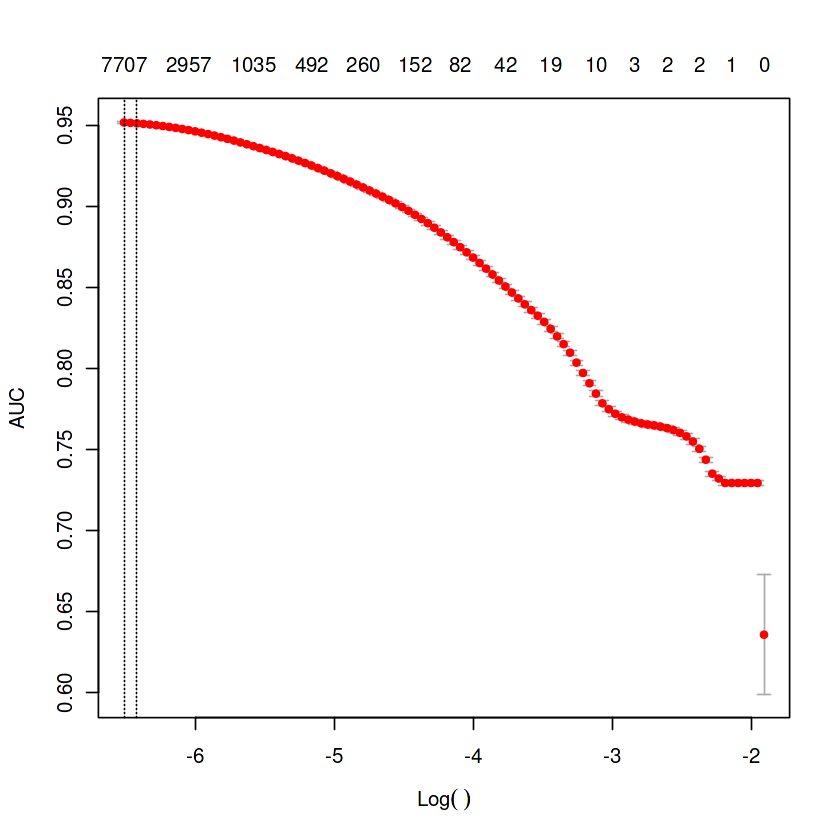

In [30]:
# Cross-validate the lambda parameter
fit_cv_lasso = cv.glmnet(
  train_X1,
  train_y,
  family = "binomial",
  parallel = TRUE,
  type.measure = "auc",
  alpha = 1 # 1 for LASSO
)

# Output result
fit_cv_lasso

# Output best lambda and show in plot
fit_cv_lasso$lambda.min
plot(fit_cv_lasso)

# Output AUC for the best lambda
best_auc_lasso <- fit_cv_lasso$cvm[fit_cv_lasso$lambda == fit_cv_lasso$lambda.min]
print(best_auc_lasso)
# print(best_auc_lasso)

Output:

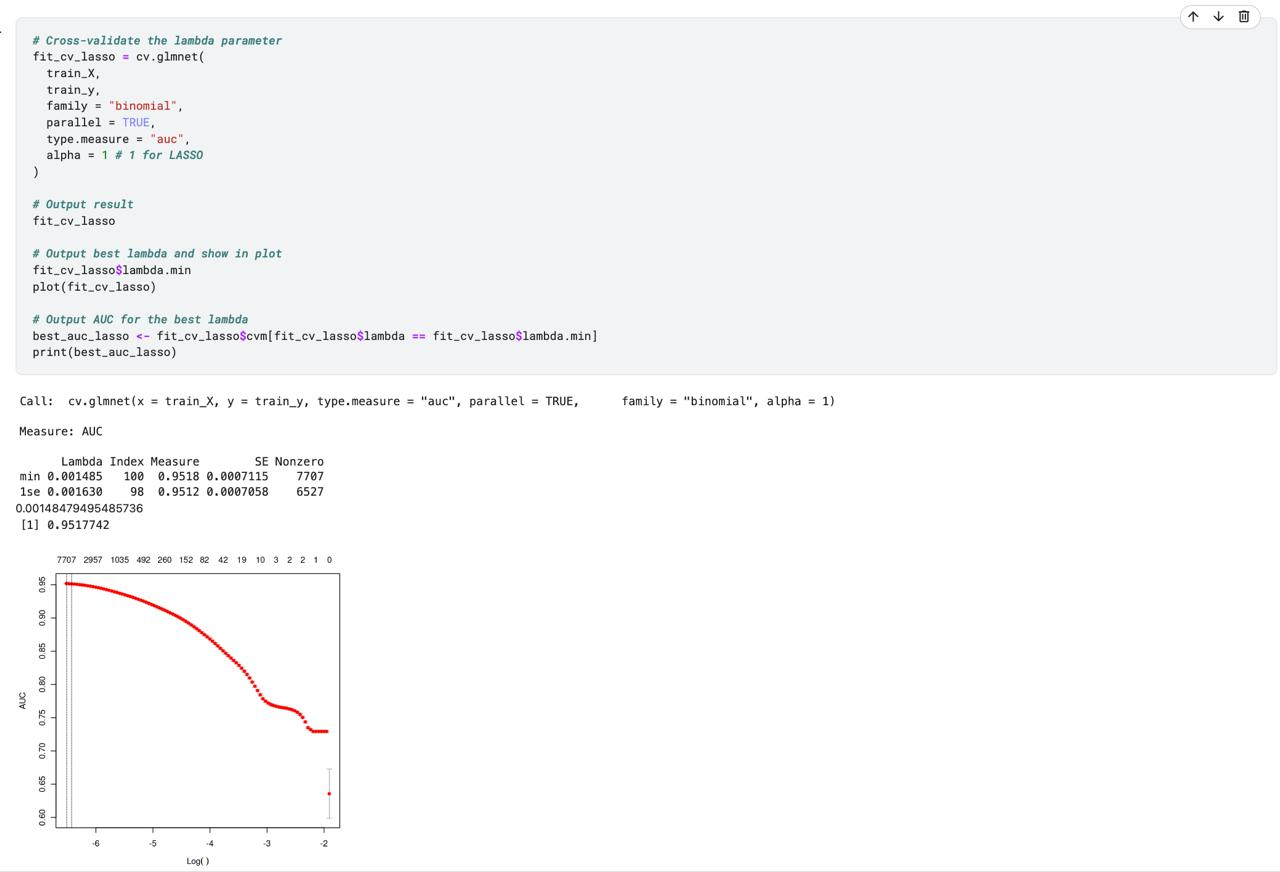

From the output we can see that the Lasso model reduces the features to 7707 non-zero predictors. We started out with 193,751 predictors, meaning the the **number of features was reduced by 96.02%**. 

The lambda that yields this number of non-zero predictors, **lambda = 0.0015**, gives us an **AUC of 0.9518**. Since an AUC of 0.5 would indicate guessing probability and and AUC of 1.0 would mean that the model is performing perfectly, this is a good first AUC!

### 5.1.2 Ridge Full Inclusion 
Next, we will try a Ridge regression with all available features. Ridge regression is also a technique that improves linear regression models by adding a regularization term to prevent overfitting. It does also add a penalty for model complexity, but this penalty will shrink some of the coefficients but they will not be zero, meaning all predictors will remain in the model. 

The key difference between Lasso and Ridge is how they handle the coefficients. Lasso can set some coefficients to zero, performing automatic feature selection, whereas Ridge only shrinks coefficients but retains all variables.

In [31]:
# Cross-validate the lambda parameter
# fit_cv_ridge <- cv.glmnet(
#    train_X1, # feature set 1 (full inclusion)
#    train_y, 
#    family = "binomial",
#    parallel = FALSE, 
#    type.measure = "auc",
#    alpha = 0) # 0 for Ridge
 
# Output result
# fit_cv_ridge
 
# Output best lambda and show in plot
# fit_cv_ridge$lambda.min 
# plot(fit_cv_ridge)
 
# Output AUC for the best lambda
# best_auc_ridge <- fit_cv_ridge$cvm[fit_cv_ridge$lambda == fit_cv_ridge$lambda.min]
# print(best_auc_ridge)

Output: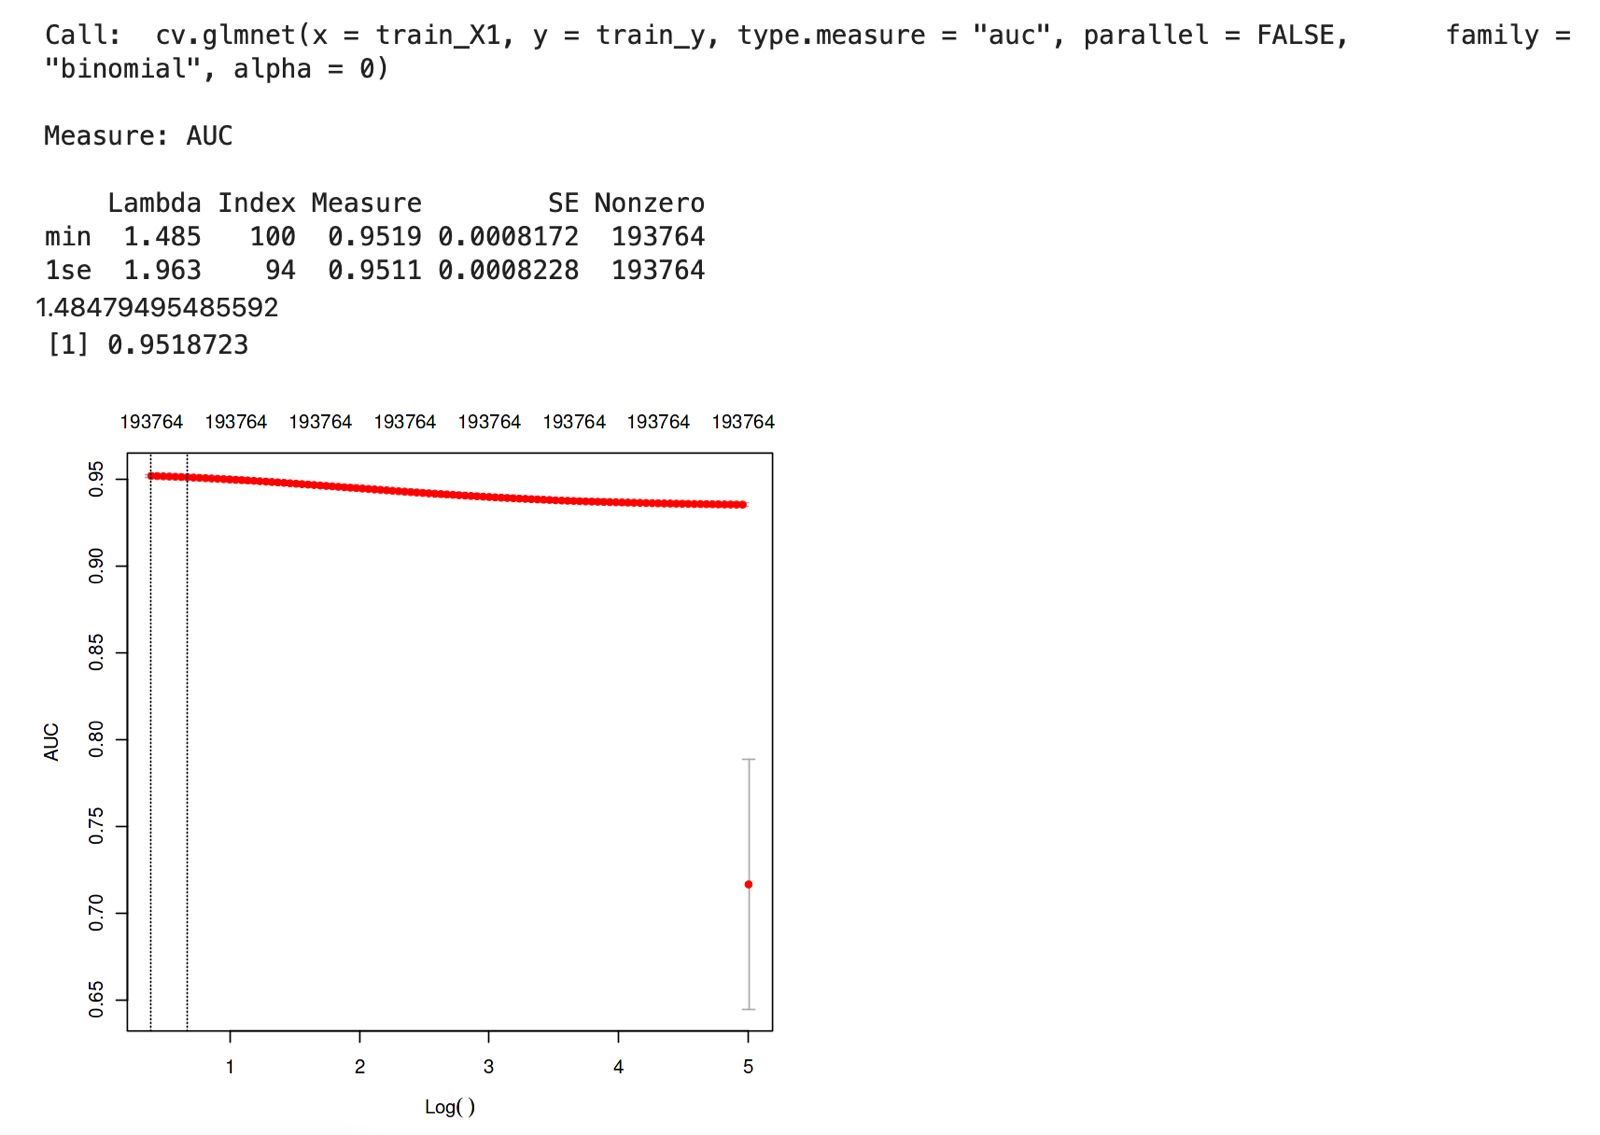

From the output, we can see that the Ridge Model has retained all variables as non-zero. However, not because all features are useful but due to the mechanism of the ridge that shrinks the coefficients towards zero but never being exactly zero. The ridge therefore by default retains all the variables. 

The output indicates that the **optimal lambda is 1.485** and the **AUC is 0.9519** at that point, suggesting a very accurate model. The AUC is even *very* slightly higher than for the Lasso model (AUC_Lasso = 0.9519). Going from numbers alone, we would therefore say that the Ridge model fits the training data a bit better. However, in the previous round, when we had not set a seed yet, we had the opposite result of Lasso being better than Ridge, suggesting that there is a certain amount of randomness in these estimates. 

We decided to think practically here: The ridge model took very long to fit and often even failed, probably because it placed too high of a load onto the servers. The Lasso model’s AUC is to a very high degree comparable to the Ridge's. In addition, the Lasso model can be considered sparser, because it actually pushes the majority of cofficients to zero, and not only near-zero. This also makes it clearer to see what the actually important features are and easier to interpret. 

Therefore, we decided to opt for the Lasso technique and fit our remaining models, where we experiment with different n-grams and lexicon features only, with this Lasso technique. This will also help us in our insight into what features are most important.  

### 5.1.3 Lasso: Global, Lexicon and Bigram TF-IDF features
Next, we are going to train the model that considers the global and lexicon features, like before, but this time only the bigram tf-idf features. 

In [32]:
# Cross-validate the lambda parameter
# fit_cv_lasso2 = cv.glmnet(
#   train_X2, # feature set 2 (bigram tfidf features)
#   train_y,
#   family = "binomial",
#   parallel = TRUE,
#   type.measure = "auc",
#   alpha = 1 # 1 for LASSO
# )

# Output result
# fit_cv_lasso2

# Output best lambda and show in plot
# fit_cv_lasso2$lambda.min
# plot(fit_cv_lasso2)

# Output AUC for the best lambda
# best_auc_lasso2 <- fit_cv_lasso2$cvm[fit_cv_lasso2$lambda == fit_cv_lasso2$lambda.min]
# print(best_auc_lasso2)

Output: 
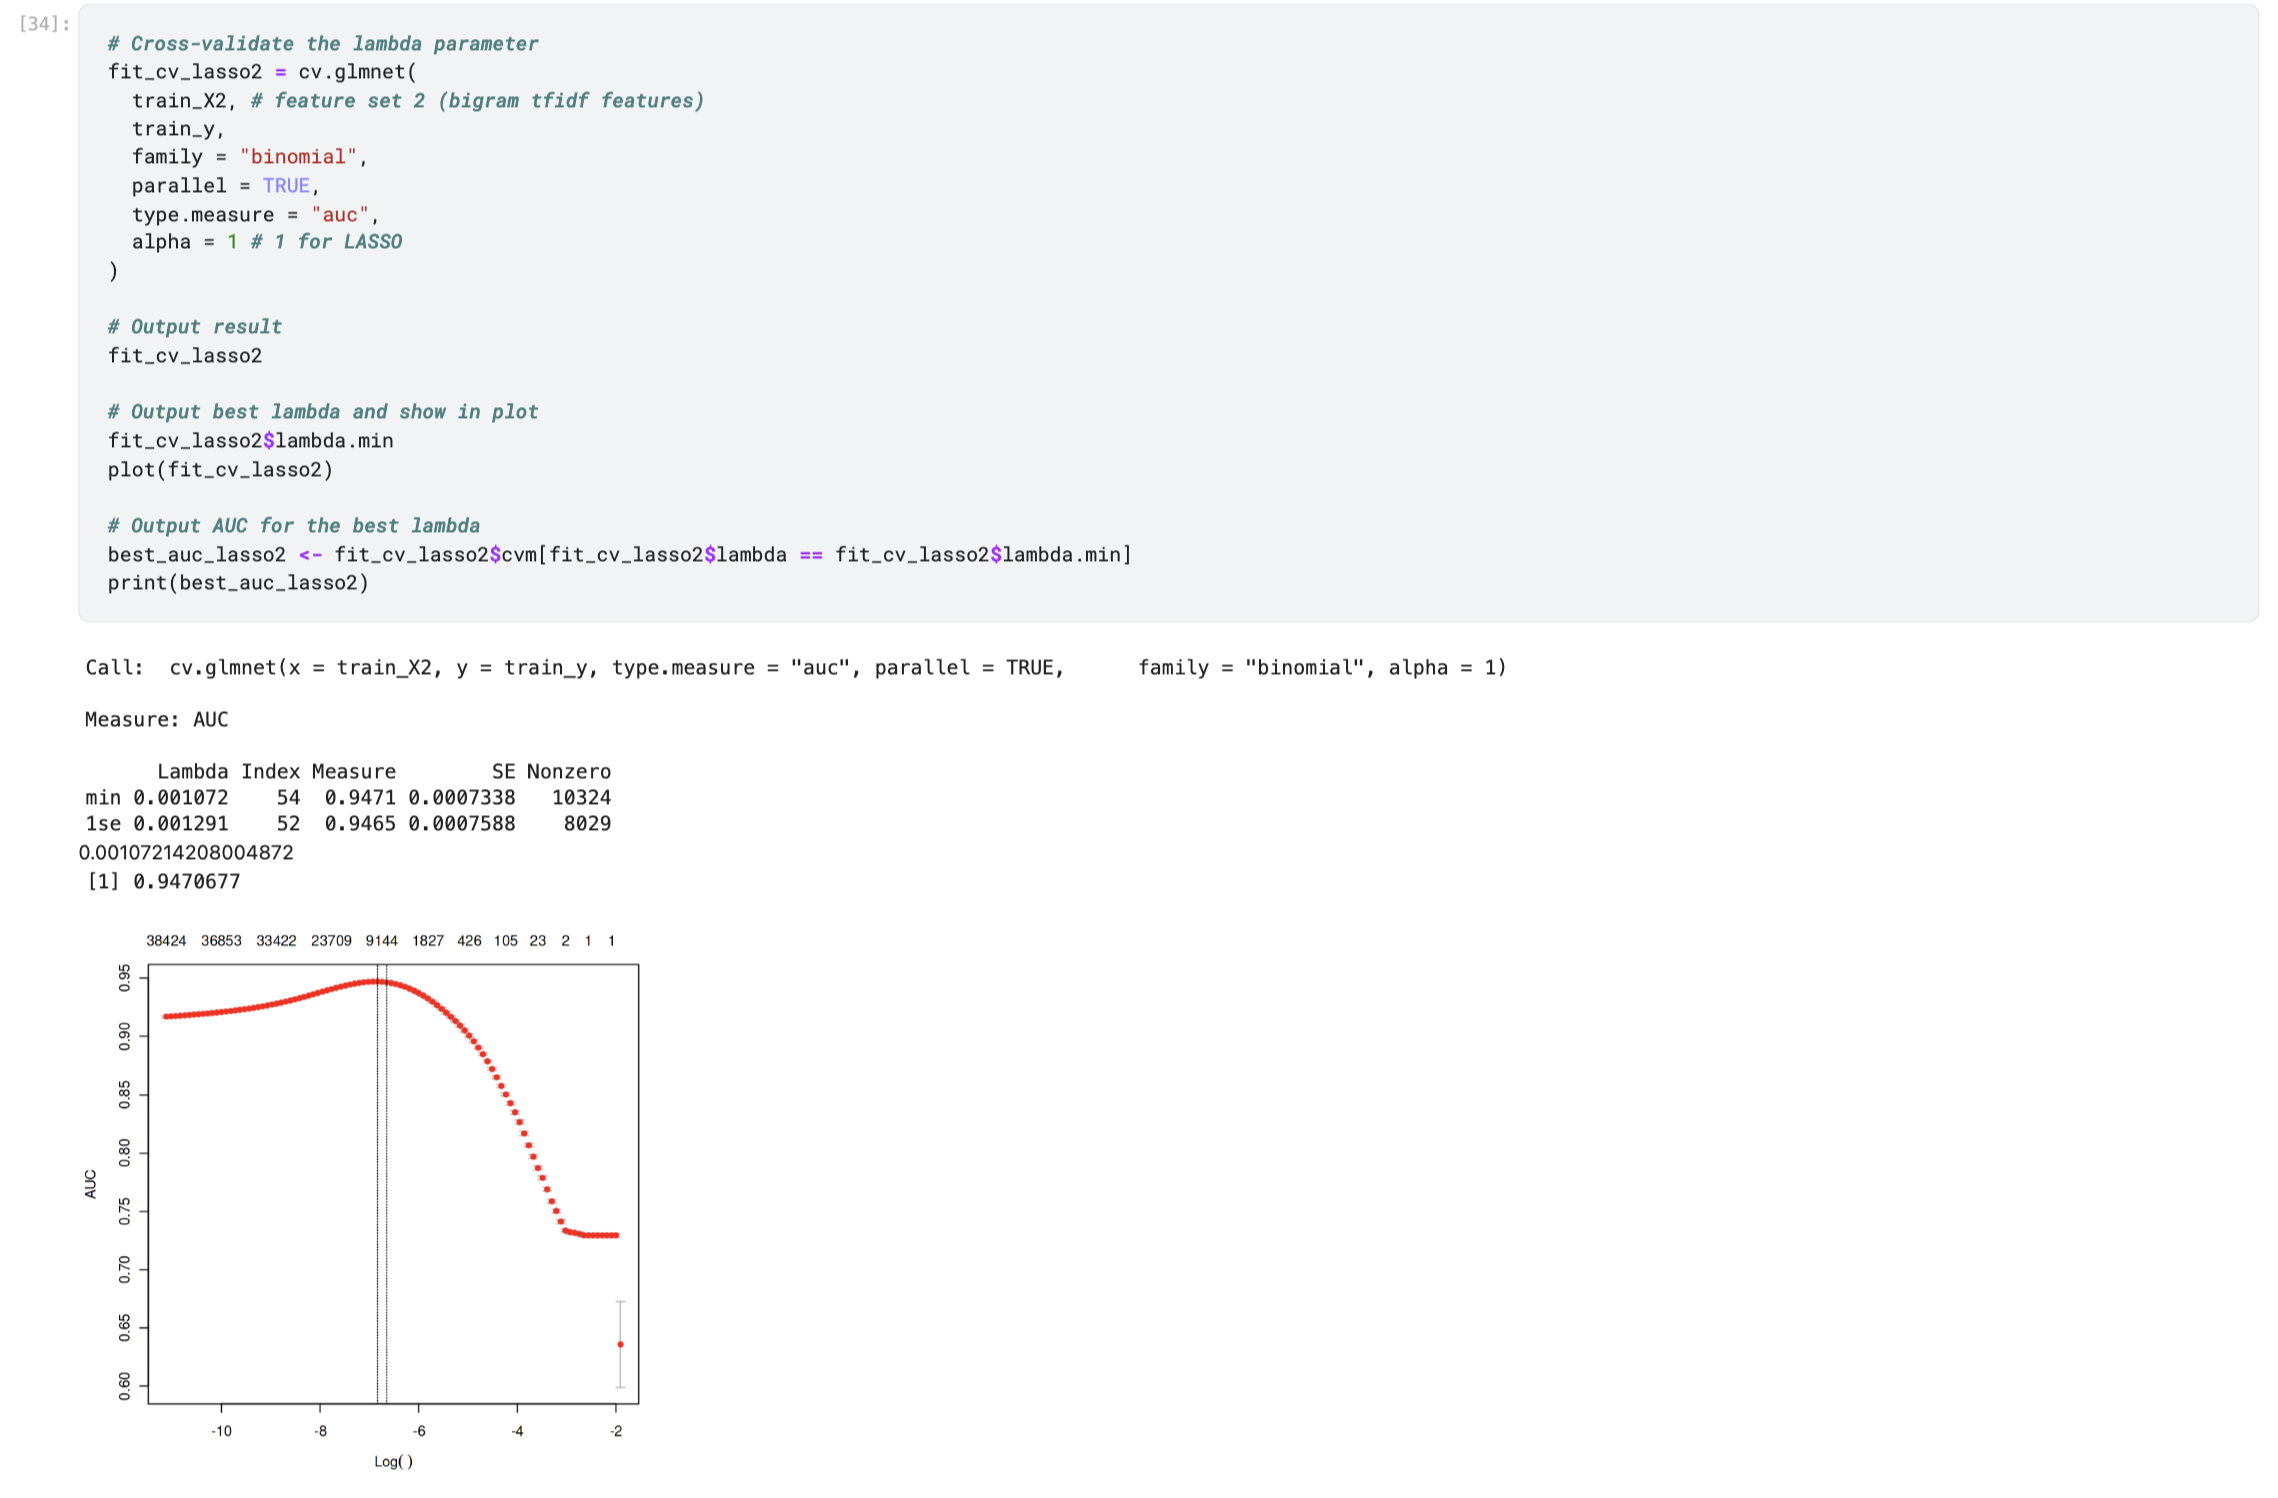

We can see that the bigram Lasso model reduces the features from 86,425 to **10,324 non-zero predictors**, meaning the the **number of features was reduced by 88.05%**.

The lambda that leads to the best fit regarding AUC, **lambda = 0.0011**, gives us an **AUC of 0.947**. This is only slightly worse than the full inclusion Lasso model was, which included uni-, bi- and trigrams as well as the global and lexicon features. Therefore, bigrams (together with global and lexicon features) seem to perform almost as well as uni-, bi- and trigrams together. However, it also retains more non-zero predictors than our full model (7707 non-zero predictors), indicating that a more diverse feature set can "allow itself" to have less predictors than a less diverse one. 

### 5.1.4 Lasso: Global, Lexicon and Trigram TF-IDF features
Next, let's see if trigrams only work better than bigrams only by fitting a model that like before, considers global and lexicon features, and in addition to that trigram tf-idf features. 

In [33]:
# Cross-validate the lambda parameter
# fit_cv_lasso3 = cv.glmnet(
#   train_X3, # feature set 3 (trigram tfidf features)
#   train_y,
#   family = "binomial",
#   parallel = TRUE,
#   type.measure = "auc",
#   alpha = 1 # 1 for LASSO
# )

# Output result
# fit_cv_lasso3

# Output best lambda and show in plot
# fit_cv_lasso3$lambda.min
# plot(fit_cv_lasso3)

# Output AUC for the best lambda
# best_auc_lasso3 <- fit_cv_lasso3$cvm[fit_cv_lasso3$lambda == fit_cv_lasso3$lambda.min]
# print(best_auc_lasso3)


Output: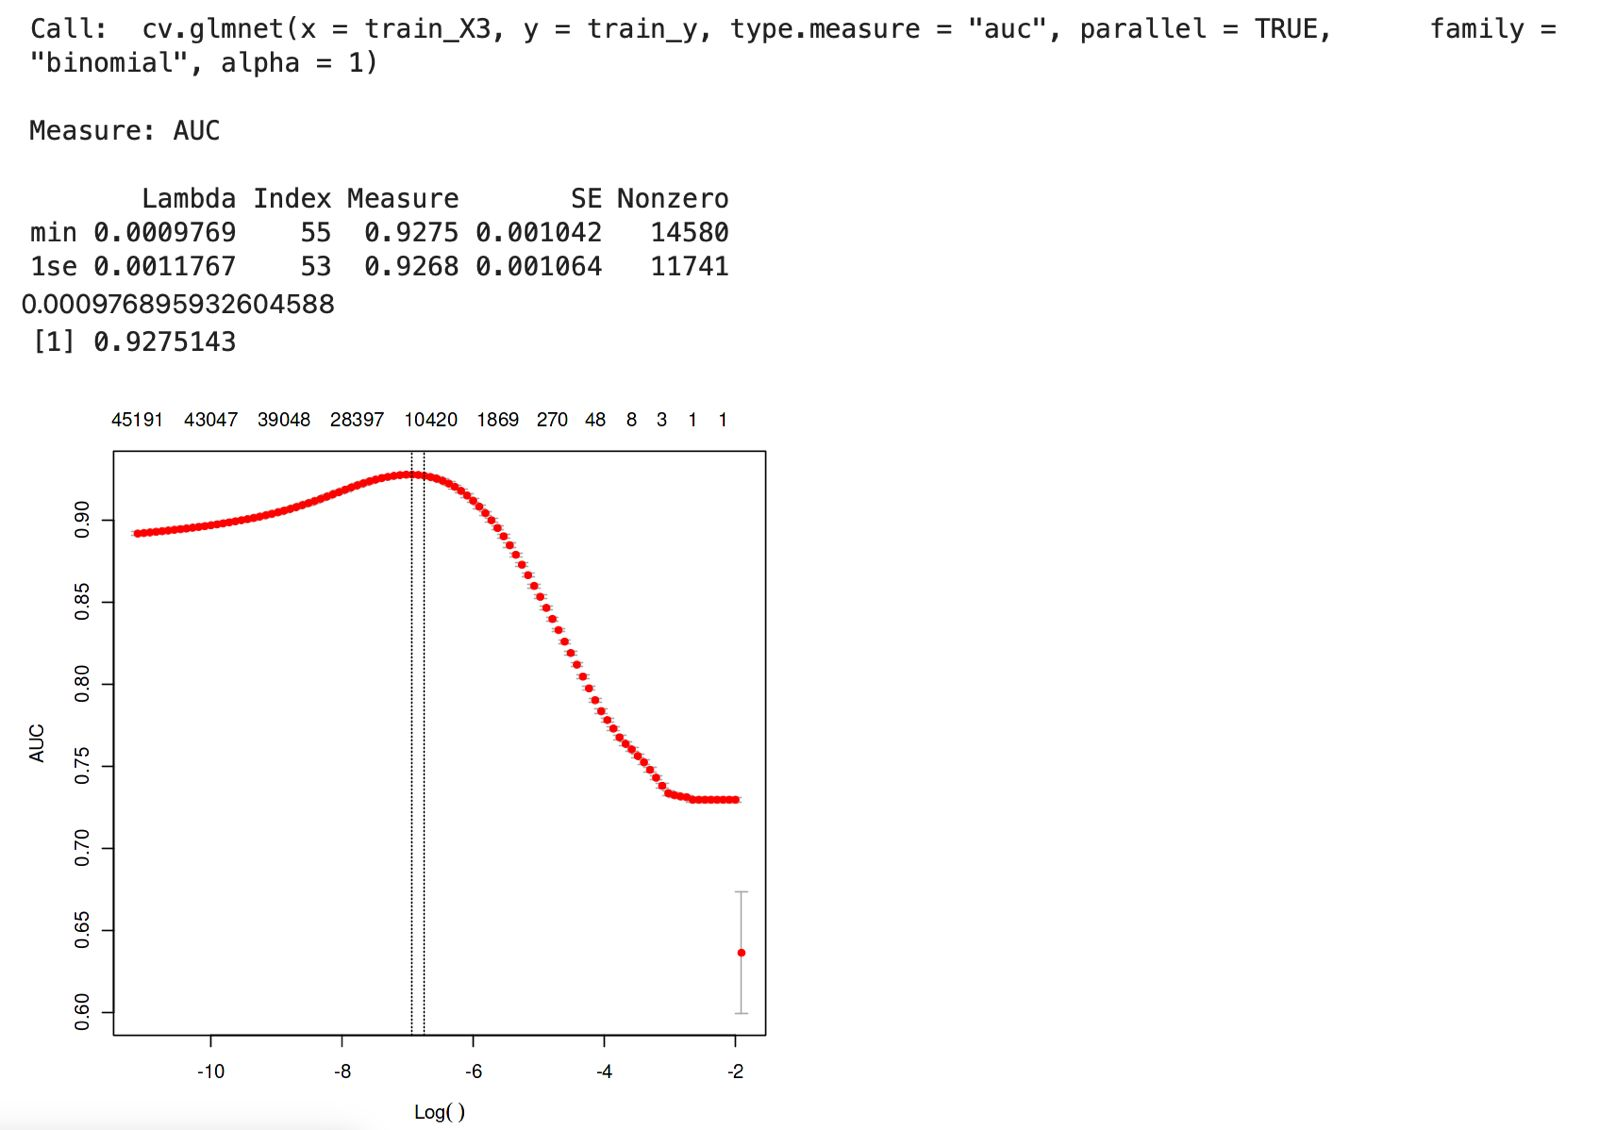

The trigram Lasso model reduces the features from 94,506 to *14,580 non-zero predictors, meaning the the **number of features was reduced by 84.57%*.

The lambda that leads to the best fit regarding AUC, **lambda = 0.0001**, gives us an **AUC of 0.928**. This is a bit worse than the full inclusion Lasso and bigram Lasso model. At the same time, this model retains the most amount of features. Therefore we would say that this model is the worst so far, since it yields the lowest AUC and is the least sparse.

### 5.1.5:  Lasso Lexicon Features Only
What if we do not even need our huge matrix of tf-idf to accurately predict whether a customer is satisfied or not? Could this be predicted just as well by only considering our lexicons which are engineered to predict sentiments? Let's see how accurate our training predictions are if we consider only lexicon features: 

In [34]:
# Cross-validate the lambda parameter for Lasso (alpha = 1 for Lasso)
# fit_cv_lasso4 <- cv.glmnet(
#   train_X4, # 4 for lexicon features only
#   train_y,  
#   family = "binomial",  
#   parallel = TRUE,
#   type.measure = "auc",  
#   alpha = 1  # Alpha = 1 for Lasso regression
# )

# Output result
# fit_cv_lasso4

# Output best lambda and show in plot
# fit_cv_lasso4$lambda.min
# plot(fit_cv_lasso4)

# Output AUC for the best lambda
# best_auc_lasso4 <- fit_cv_lasso4$cvm[fit_cv_lasso4$lambda == fit_cv_lasso4$lambda.min]
# print(best_auc_lasso4)


Output: 

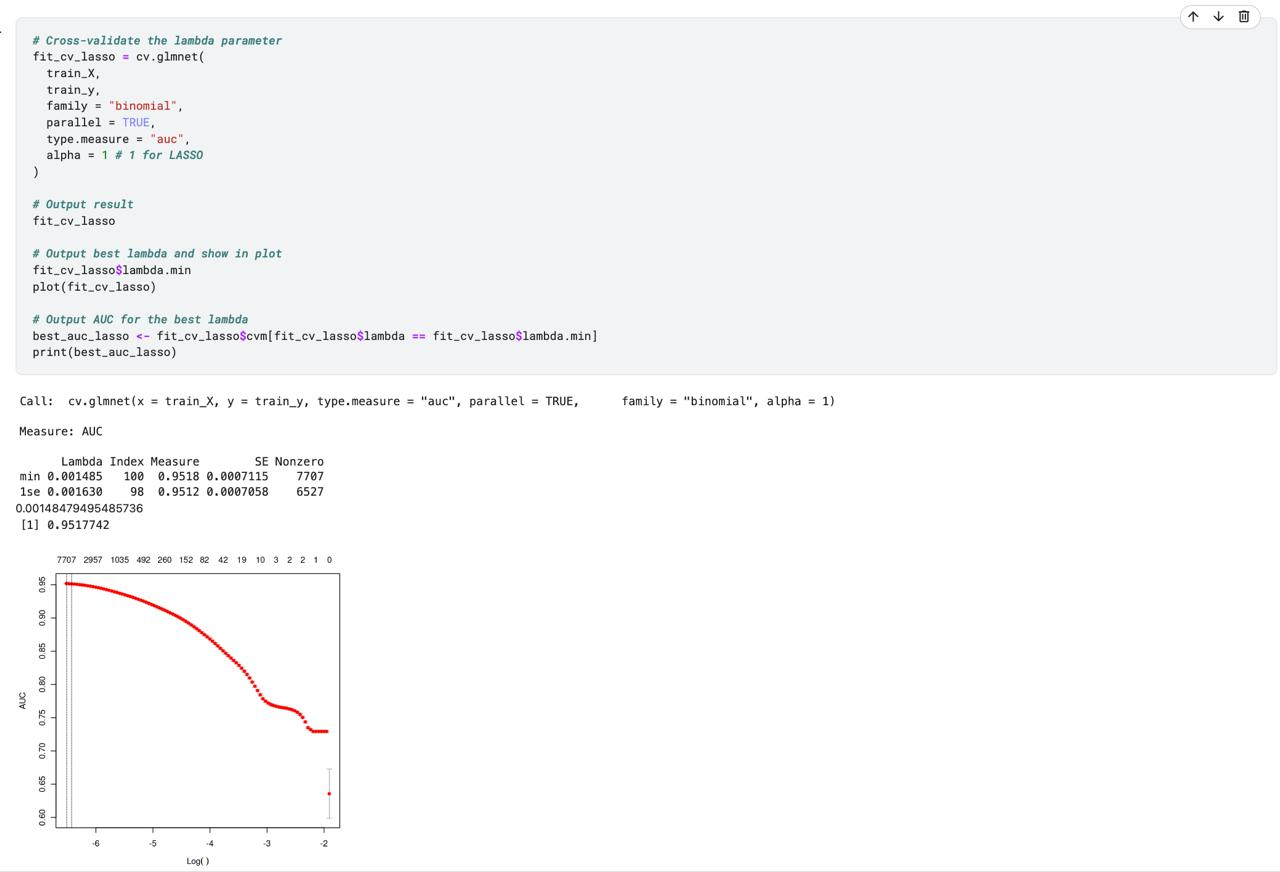

The Lasso model using lexicon features **reduces the number of non-zero predictors from 13 to 12**, with only one variable being shrunk to zero. The lambda value that results in the best fit for AUC, **lambda = 0.000423**, produces an **AUC of 0.774**, which is lower than any of the n-gram-based models. 

This outcome is not unexpected, as the Lasso model has significantly fewer variables compared to the others. Given its lower AUC, this model will not be selected over the others. 

# 5.2 Model evaluation
To evaluate our models we will compare their AUCs and accuracies. We will also plot ROC curves for our Lasso and Ridge full inclusion model to further compare the two. Lastly, for our best model, we will look at what features are most important for predicting the outcome.

## 5.2.1 Comparison of AUCs

*Because we couldn't run the models together but have the result, we manually inputed the AUC for plotting.

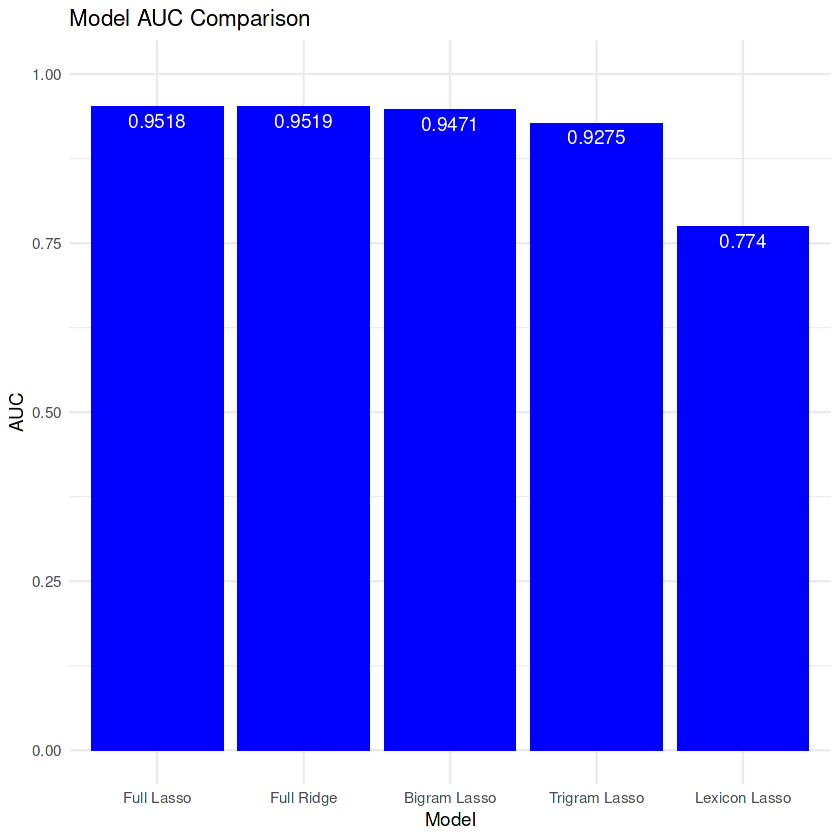

In [35]:
model_AUC <- data.frame(
  Model = c(
    "Full Lasso",
    "Full Ridge",
    "Bigram Lasso",
    "Trigram Lasso",
    "Lexicon Lasso"
  ),
  AUC = c(0.9518, 0.9519, 0.9471, 0.9275, 0.7740)
)

# Prevent ggplot from sorting the bars alphabetically
model_AUC$Model <- factor(model_AUC$Model, levels = model_AUC$Model)

ggplot(model_AUC, aes(x = Model, y = AUC)) +
  geom_bar(stat = "identity", fill = "blue") +
  geom_text(aes(label = AUC), vjust = 1.5, color = "white") +
  ylim(0, 1) +
  labs(title = "Model AUC Comparison", x = "Model", y = "AUC") +
  theme_minimal()

We can see that Full Lasso, full Ridge, and bigram Lasso are very close to each other, and then trigram Lasso performs a bit worse, whereas lexicon lasso, which doesn't include any tdidf features, yields the worst AUC results. 

## 5.2.3 Accuracy 

*Given that we don't have the model output to calculate the accuracy here, we illustrate their accuracy in the plot specifying their respective accuracy.

As a second performance indicator, next to AUC, we want to compare the models' **accuracies**. Accuracy is the proportion of correct predictions (both positive and negative) over the total number of predictions, here at the threshold .5. The no-information rate of the data is 76%, meaning that a model just by guessing the dominant rating (satisfied in this case) will be correct 76% of the time. 
We start with the LASSO full inclusion model's accuracy:

#### 5.2.3.1 Lasso Full Inclusion

In [36]:
# Make predictions (in probabilites)
pred_lasso_train <- predict(
  object = fit_cv_lasso,
  newx = train_X1,
  s = fit_cv_lasso$lambda.min,
  type = 'response'
)

# Convert predictions to binary outcomes
pred_labels_lasso_all <- ifelse(pred_lasso_train > 0.5, 1, 0)

# Confusion matrix
table(Predicted = pred_labels_lasso_all, Actual = train_y)

# Accuracy
accuracy_all <- mean(pred_labels_lasso_all == train_y)
accuracy_all

         Actual
Predicted  FALSE   TRUE
        0  28095   2832
        1   8098 114506

ERROR: Error in eval(expr, envir, enclos): object 'accuracy' not found


We can see that the Lasso model achieved a high **accuracy of 93.89%**. It produced more false positives (7,067) compared to false negatives (2,315). This means that the model tends to predict the positive class more often, even when the actual label is negative. Further, the lasso model yields significantly better results than the no-information rate.


Now, let's look at the accuracy of the Ridge regression:

#### 5.2.3.2 Ridge Full Inclusion

In [ ]:
# Make predictions (in probabilities)
# pred_ridge_train <- predict(
#   object = fit_cv_ridge,
#   newx = train_X1,
#   s = fit_cv_ridge$lambda.min,
#   type = 'response'
# )
 
# Convert predictions to binary outcomes
# pred_labels_ridge <- ifelse(pred_ridge_train > 0.5, 1, 0)
 
# Confusion matrix
# table(Predicted = pred_labels_ridge, Actual = train_y)
 
# Accuracy
# accuracy <- mean(pred_labels_ridge == train_y)
# accuracy

Output: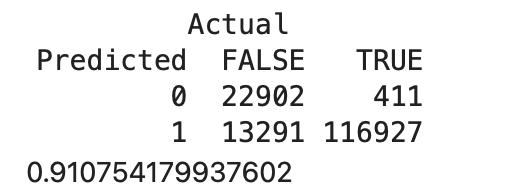

#### 5.2.3.3 Lasso Bigrams

In [ ]:
# Make predictions (in probabilities)
# pred_lasso_train_bi <- predict(
#   object = fit_cv_lasso2,
#   newx = train_X2,
#   s = fit_cv_lasso2$lambda.min,
#   type = 'response'
# )

# Convert predictions to binary outcomes
# pred_labels_lasso_bi <- ifelse(pred_lasso_train_bi > 0.5, 1, 0)

# Confusion matrix
# table(Predicted = pred_labels_lasso_bi, Actual = train_y)

# Accuracy
# accuracy_bi <- mean(pred_labels_lasso_bi == train_y)
# accuracy_bi

Output:
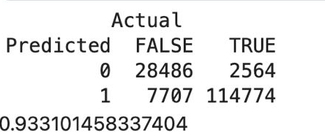

#### 5.2.3.4 Lasso Trigrams

In [ ]:
# Make predictions (in probabilities)
# pred_lasso_train_tri <- predict(
#   object = fit_cv_lasso3,
#   newx = train_X3,
#   s = fit_cv_lasso3$lambda.min,
#   type = 'response'
# )

# Convert predictions to binary outcomes
# pred_labels_lasso_tri <- ifelse(pred_lasso_train_tri > 0.5, 1, 0)

# Confusion matrix
# table(Predicted = pred_labels_lasso_tri, Actual = train_y)

# Accuracy
# accuracy_tri <- mean(pred_labels_lasso_tri == train_y)
# accuracy_tri

Output:
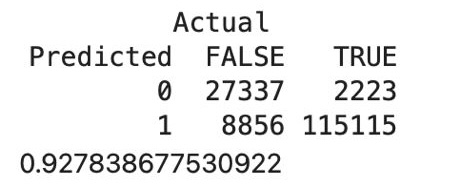

#### 5.2.3.5 Lasso Lexicon

In [ ]:
# Make predictions (in probabilities)
# pred_lasso_train_lexicon <- predict(
#   object = fit_cv_lasso4,
#   newx = train_X4,
#   s = fit_cv_lasso4$lambda.min,
#   type = 'response'
# )

# Convert predictions to binary outcomes
# pred_labels_lasso_lexicon <- ifelse(pred_lasso_train_lexicon > 0.5, 1, 0)

# Confusion matrix
# table(Predicted = pred_labels_lasso_lexicon, Actual = train_y)

# Accuracy
# accuracy_lexicon <- mean(pred_labels_lasso_lexicon == train_y)
# accuracy_lexicon

Output:
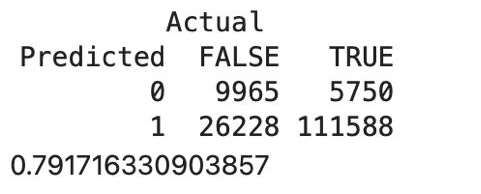

#### 5.2.3.6 Visual Comparison

In [ ]:
# Plotting model 
model_acc <- data.frame(
  Model = c(
    "Full Lasso",
    "Full Ridge",
    "Bigram Lasso",
    "Trigram Lasso",
    "Lexicon Lasso"
  ),
  Accuracy = c(0.9288, 
              0.9108, 
              0.9331,
              0.9278,
              0.7917)
)

# Prevent from sorting alphabetically
model_acc$Model <- factor(model_acc$Model, levels = model_acc$Model)

ggplot(model_acc, aes(x = Model, y = Accuracy)) +
  geom_bar(stat = "identity",
           fill = "blue") +
  geom_text(aes(label = Accuracy), vjust = 1.5, color = "white") + 
  ylim(0, 1) +
  labs(title = "Model Accuracy Comparison", x = "Model", y = "Accuracy") +
  theme_minimal()

This visual comparison shows that the models containing different n-grams are close to each other with regard to accuracy, whereas, again, the lexicon lasso model yields a significantly lower accuracy. Bigram lasso yields the best accuracy, corroborating that it is a very good model. We will still go with lasso full inclusion for our prediction, because it uses the overall least amount of features.


# 6. Submitting your predictions

In [ ]:
# Prediction based on Lasso
submission <- predict(
    fit_cv_lasso, 
    newx = test_X1, 
    s = fit_cv_lasso$lambda.min, 
    type = 'response'
) %>%
    as.data.frame() %>%
    mutate(Id = test_ids) %>%  
    rename(Prediction = s1) %>% 
    select(Id, Prediction) %>%
    arrange(as.numeric(Id)) %>%
    as_tibble()

# Check the first few rows and dimensions
head(submission)
dim(submission)


In [ ]:
# Write your predictions data frame to file
write_csv(submission, file = "submission.csv")

# 7. Division of Labor

Svenja: Prepares features for modeling, splitting data, fitting lasso and ridge, notebook styling  

Eleon: Parts of feature engineering, evaluating ridge, notebook styling  

Lasse: Tokenization, other parts of feature engineering, evaluating lasso, notebook styling

Even tough we had indivudual parts we helped each other out and collaborated for all parts together. 